In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_master = pd.read_csv("../data/CASP004-01/masterfile.csv")
df_master['product_brand'] = df_master['product_brand'].str.rstrip()
materials = pd.read_csv("../data/CASP004-01/raw/materials.csv")

def correct_product_brand_spacing(df, column_name):
    """
    Adjusts spacing around slashes in a DataFrame column.

    Parameters:
    - df: DataFrame to modify.
    - column_name: Column for spacing correction.

    Returns:
    - Modified DataFrame with standardized spacing around slashes.
    
    Spaces are normalized around slashes within the specified column.
    """
    # Add a space before the slash if it's not there and remove extra spaces after the slash
    df[column_name] = df[column_name].str.replace(r'/', ' / ').str.replace(r'\s+', ' ', regex=True)
    return df

df_master = correct_product_brand_spacing(df_master, 'product_brand')
df_master = pd.merge(df_master, materials, on='product_name')
df_master['material_I'] = df_master['material_I'].str.replace('Bioopolymer', 'Biopolymer')
df_master


,org_ID,trial_ID,bag_color,bag_ID,bag_content,bag_type,bag_placement,trial_stage,product_name,product_brand_x,...,mean_weight_final_g,notes,%_not_decomposed,%_decomposed,outlier_alert,bag_set,product_brand_y,material_I,material_II,material_III
0,44547.0,44547-01-21,Green,A-1,Baseline,Standard,Top depth,Start,12 oz Hot cup / Soup bowl,BÉSICS®,...,8.11,NaN,100.00,0.00,False,A,BÉSICS®,Fiber,Lined fiber,PLA lined Paper
1,44547.0,44547-01-21,Green,A-2,Baseline,Standard,Top depth,Start,12 oz Hot cup / Soup bowl,BÉSICS®,...,8.11,NaN,100.00,0.00,False,A,BÉSICS®,Fiber,Lined fiber,PLA lined Paper
2,44547.0,44547-01-21,Green,A-3,Baseline,Standard,Top depth,Start,12 oz Hot cup / Soup bowl,BÉSICS®,...,8.11,NaN,100.00,0.00,False,A,BÉSICS®,Fiber,Lined fiber,PLA lined Paper
3,44547.0,44547-01-21,Green,A-4,Baseline,Standard,Top depth,Start,12 oz Hot cup / Soup bowl,BÉSICS®,...,8.11,NaN,100.00,0.00,False,A,BÉSICS®,Fiber,Lined fiber,PLA lined Paper
4,44547.0,44547-01-21,Green,A-5,Baseline,Standard,Bottom depth,Start,12 oz Hot cup / Soup bowl,BÉSICS®,...,8.11,NaN,100.00,0.00,False,A,BÉSICS®,Fiber,Lined fiber,PLA lined Paper
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,44547.0,44547-01-21,Pink,B-2,Custom,Standard,Top depth,End,Wrapper for TPLA Spoon SP-PS-I,World Centric™,...,0.00,NaN,0.00,100.00,False,B,World Centric™,Biopolymer,Film,Mixed biopolymer
968,44547.0,44547-01-21,Pink,B-3,Custom,Standard,Top depth,End,Wrapper for TPLA Spoon SP-PS-I,World Centric™,...,0.55,NaN,67.07,32.93,False,B,World Centric™,Biopolymer,Film,Mixed biopolymer
969,44547.0,44547-01-21,Pink,B-4,Custom,Standard,Top depth,End,Wrapper for TPLA Spoon SP-PS-I,World Centric™,...,1.28,NaN,156.10,-56.10,True,B,World Centric™,Biopolymer,Film,Mixed biopolymer
970,44547.0,44547-01-21,Pink,B-5,Custom,Standard,Bottom depth,End,Wrapper for TPLA Spoon SP-PS-I,World Centric™,...,0.00,NaN,0.00,100.00,False,B,World Centric™,Biopolymer,Film,Mixed biopolymer


## Outlier Analysis

In [3]:
df_non_outlier = df_master[df_master['outlier_alert']==False]
len(df_non_outlier)

844

In [4]:
df_outlier = df_master[df_master['outlier_alert']==True]
len(df_outlier)

128

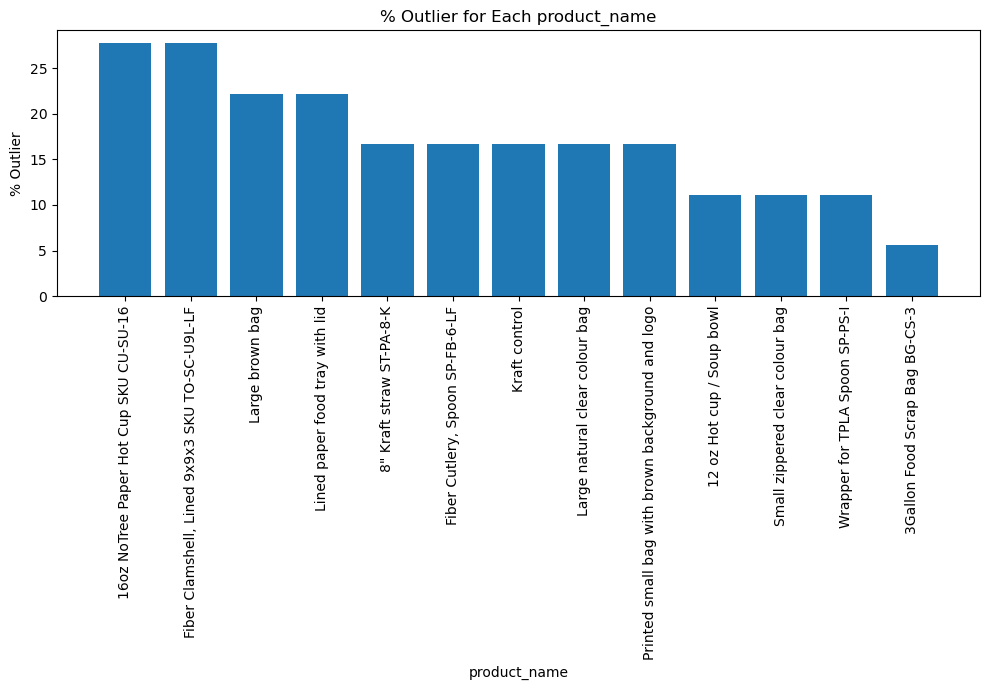

In [5]:
def outlier_plot(col):
    """
    Visualizes outlier percentages for each category in a specified column.

    Parameters:
    - col (str): Column name for outlier analysis.

    This function calculates and plots the percentage of outliers per category in 'col' using data from `df_outlier` and `df_master`. It shows these percentages in a bar chart, with categories sorted by outlier percentage.
    """
    outlier_category = df_outlier.groupby([col])['outlier_alert'].count().reset_index()
    df = df_master.groupby([col])['outlier_alert'].count().reset_index()
    outlier_category = outlier_category.merge(df, on=col)
    outlier_category['%_outlier'] = (outlier_category['outlier_alert_x'] / outlier_category['outlier_alert_y'] * 100).round(2)
    outlier_category = outlier_category.sort_values(by='%_outlier', ascending=False)
    plt.figure(figsize=(10, 7))
    plt.bar(outlier_category[col], outlier_category['%_outlier'])
    plt.title(f'% Outlier for Each {col}')
    plt.xlabel(col)
    plt.ylabel('% Outlier')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    
outlier_plot('product_name')


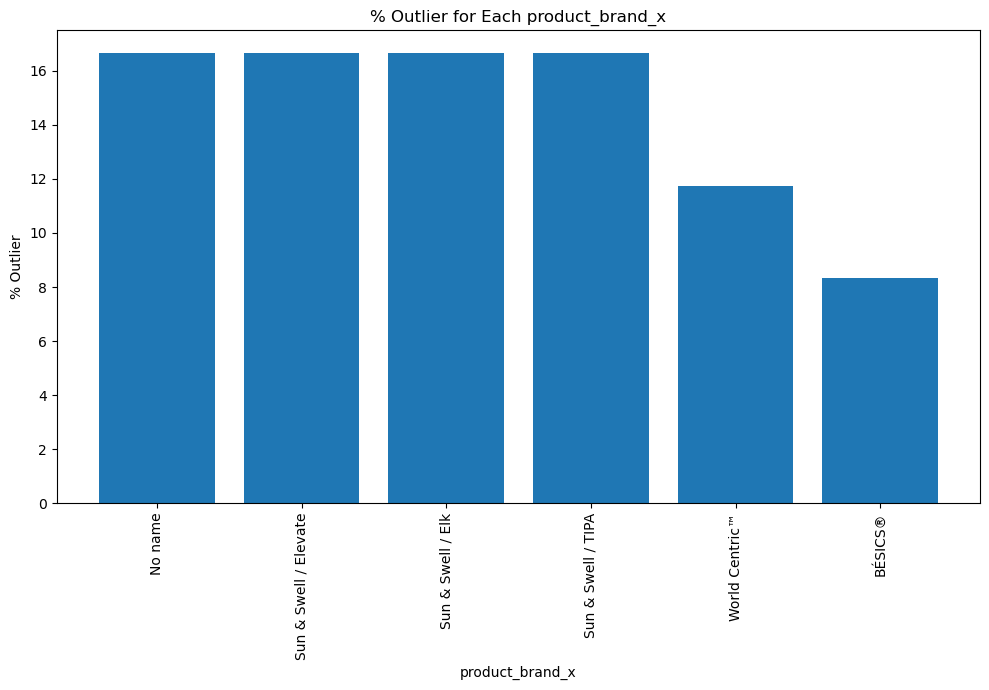

In [6]:
outlier_plot('product_brand_x')

### Plot Functions Set Up

In [7]:
df_end = df_master[df_master['trial_stage'] == 'End']
df_non_outlier = df_end[df_end['outlier_alert']==False]

def bar_whisker_plot(df, x, y, outlier):
    """
    Generates a box-and-whisker plot for visualizing distributions of 'y' across categories in 'x', considering IQR for outlier handling.

    Parameters:
    - df (pandas.DataFrame): The dataset to plot.
    - x (str): Column name for categorical data to be plotted on the x-axis.
    - y (str): Column name for numerical data to be plotted on the y-axis.
    - outlier (str): Description or condition of outliers to include in the plot title.

    This function calculates the interquartile range (IQR) for 'y' within each category of 'x', sorts categories by median 'y' where IQR > 0, appends categories with IQR = 0, and plots a boxplot with a custom color palette. Titles and axes are labeled with provided column names and outlier description.
    """
    iqr = df.groupby(x)[y].apply(lambda g: g.quantile(0.75) - g.quantile(0.25))
    nonzero_iqr_order = df[df[x].isin(iqr[iqr > 0].index)].groupby(x)[y].median().sort_values(ascending=False).index
    zero_iqr_order = iqr[iqr == 0].index
    order = nonzero_iqr_order.append(zero_iqr_order)
    plt.figure(figsize=(12, 8))
    unique = df[x].nunique()
    palette = sns.color_palette("husl", unique) 
    sns.boxplot(data=df, x=x, y=y, order=order, palette=palette)
    plt.title(f'{y} for Each {x} {outlier}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def plot_violin(df, x, y):
    """
    Creates a violin plot for a given numerical variable across different categories of another variable.

    Parameters:
    - df (pandas.DataFrame): The dataset containing the variables to plot.
    - x (str): Column name for the categorical variable to be displayed on the x-axis.
    - y (str): Column name for the numerical variable to be displayed on the y-axis.

    This function visualizes the distribution of 'y' across the categories in 'x' using a violin plot, helping to identify the distribution, median, and spread within each category. The plot is customized with the "viridis" color palette.
    """
    plt.figure(figsize=(8, 5))
    sns.violinplot(x=x, y=y, data=df, palette="viridis")
    plt.title('Violin Plot of % Residual for Each {x} Type')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## Average Weight Pre and Post Composting

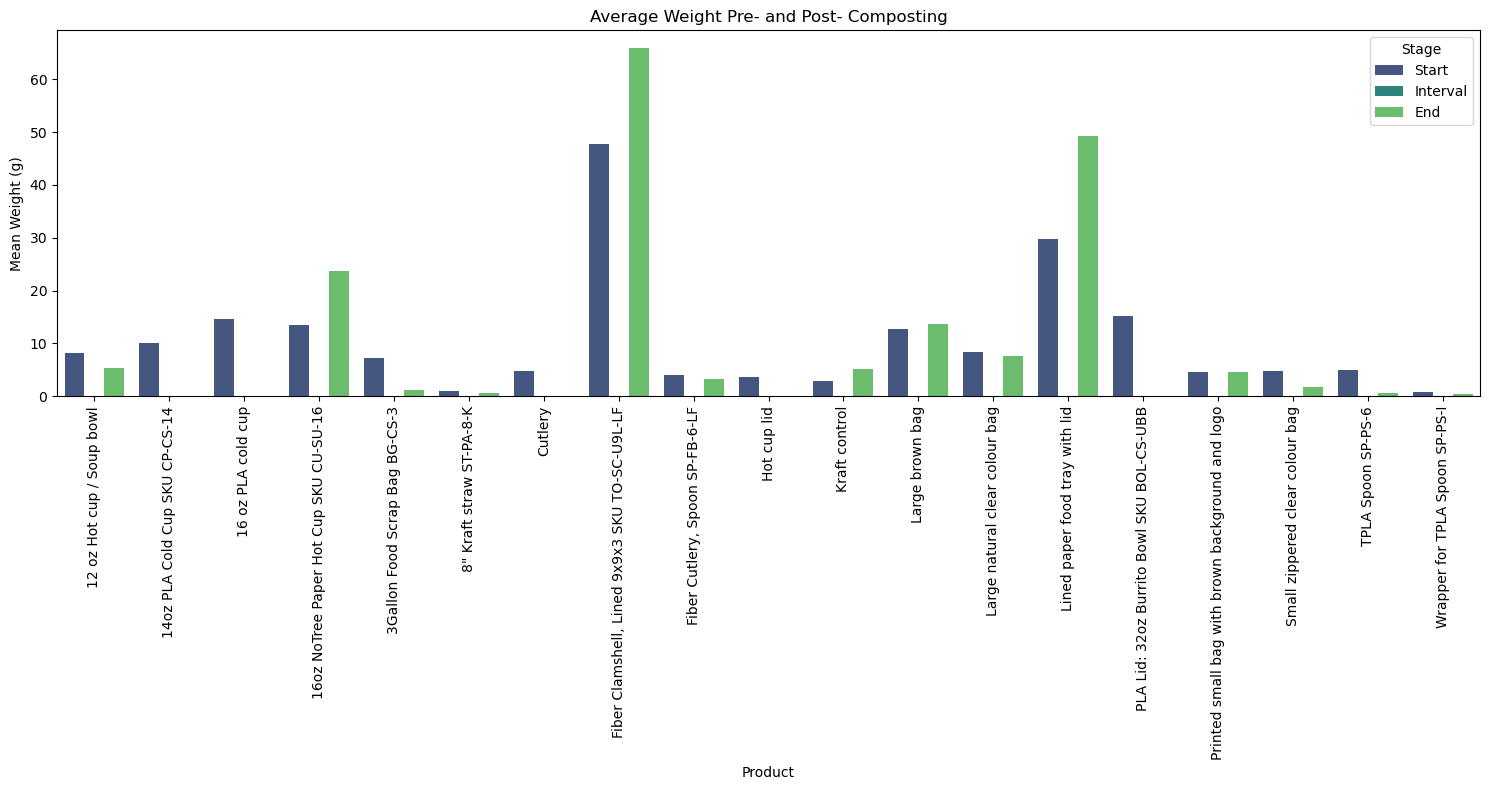

In [8]:
stage_order = pd.CategoricalDtype(
    categories=["Start", "Interval", "End"],
    ordered=True
)
df_master['trial_stage'] = df_master['trial_stage'].astype(stage_order)

stages_ordered = df_master.groupby(['product_name', 'trial_stage'])['mean_weight_final_g'].mean().reset_index().round(2)
plt.figure(figsize=(15, 8))
sns.barplot(x='product_name', y='mean_weight_final_g', hue='trial_stage', data=stages_ordered, palette="viridis")
plt.title('Average Weight Pre- and Post- Composting')
plt.xlabel('Product')
plt.ylabel('Mean Weight (g)')
plt.xticks(rotation=90)
plt.legend(title='Stage')
plt.tight_layout()
plt.show()


- As the CASP004-001 trial lacks data for the interval stage, the plot displays the average weight change of products by comparing the mean weight from start to the end of the trial. Notably, while some products completely decomposed, others, such as the 16oz No Tree Paper Hot Cup and the Fiber Clamshell, actually gained weight.

- Therefore, we tagged the products that add weight during decomposition as **anomalies**.

    For each observation, we check whether the final post-decomposition weight is smaller than the original manufacturing weight of the product tested. If this is not true, this product likely clumped with other products and represents an anomaly. We tagged it as an anomaly (column `outlier_alert`) so that we can perform anomaly specific analyses downstream. 

## % Residual by Products

- In this analysis, we have plotted the percentage of residuals by products for all data, as well as for data excluding anomalies. 

- Products are arranged on the x-axis according to their median values. 

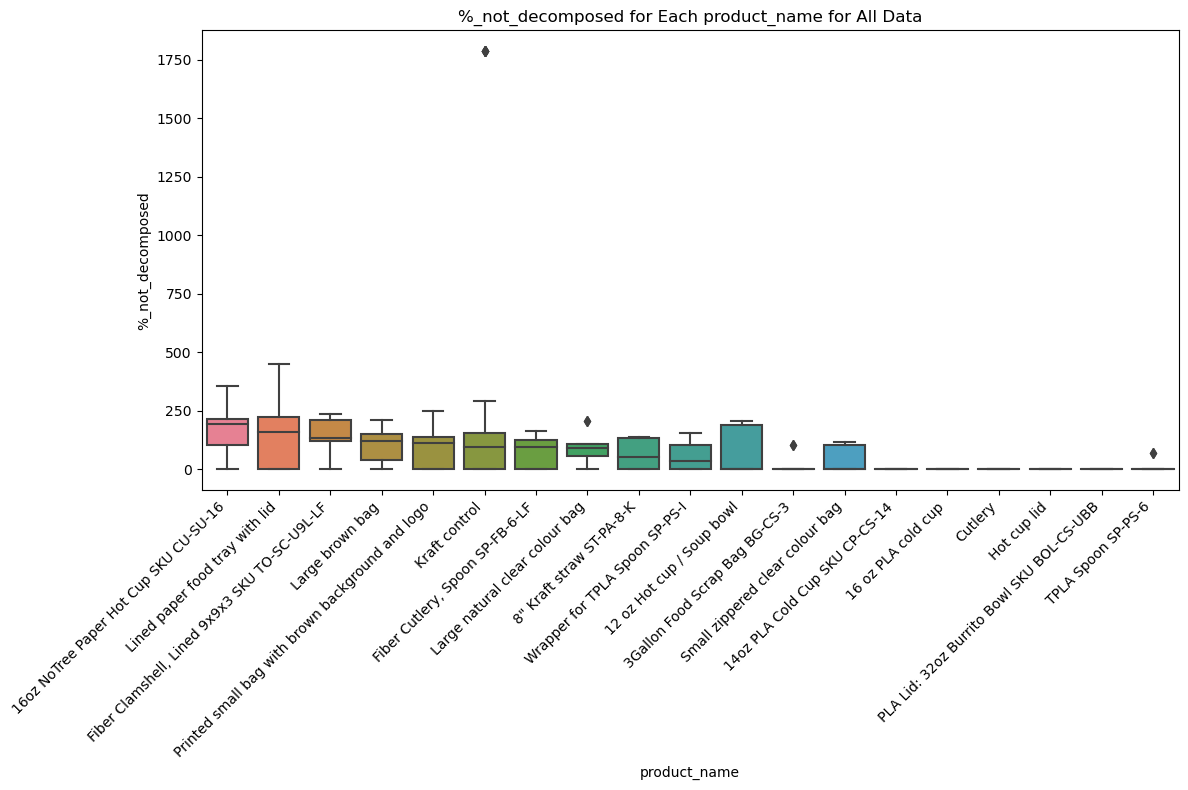

In [9]:
bar_whisker_plot(df_end, 'product_name', '%_not_decomposed', 'for All Data')

- From the first plot, it is evident that the 'kraft control' product shows an exceptionally high percentage of non-decomposition, specifically 1750%. This extreme value could potentially affect other aspects of the plot, i.e. scaling.

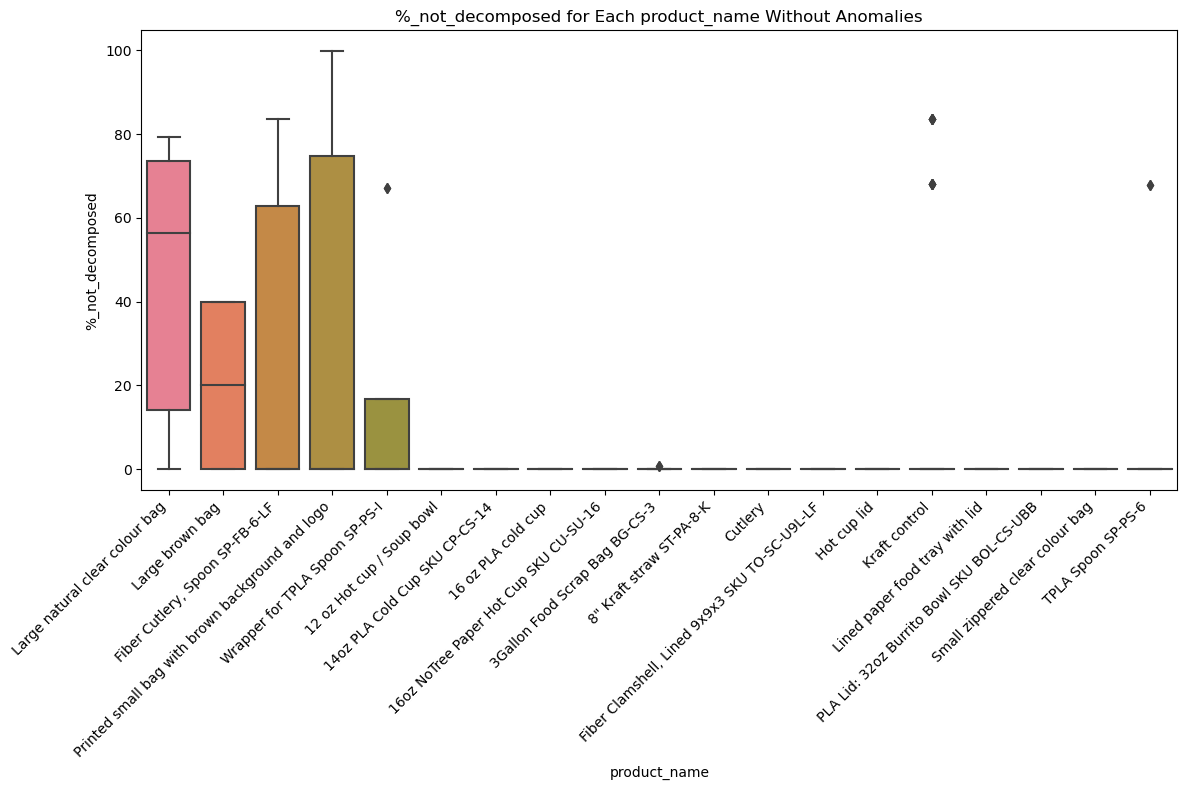

In [10]:
bar_whisker_plot(df_non_outlier, 'product_name', '%_not_decomposed', 'Without Anomalies')

- In the second plot, where all anomalies have been removed, we observe that the majority of the products have completely decomposed, indicated by their minimum, 25th percentile, median, and 75th percentile values all registering at 0. This results in them converging into a single line at 0.

## % Residual by Material Class I


In [11]:
from adjustText import adjust_text

def bar_whisker_plot_annotate(df, x, y, outlier):
    """
    Creates an annotated box-and-whisker plot to visualize the distribution of 'y' across categories in 'x', highlighting outliers.

    Parameters:
    - df (pandas.DataFrame): The dataset, expected to include 'product_name' along with 'x' and 'y'.
    - x (str): The categorical variable for the x-axis.
    - y (str): The numerical variable for the y-axis.
    - outlier (str): Description of the outlier condition to include in the plot title.

    This function performs the following steps:
    1. Drops NA values from the specified columns.
    2. Calculates IQR for 'y' within each 'x' category to determine plot order.
    3. Creates a boxplot sorted by median 'y' where IQR > 0, appending categories with IQR = 0.
    4. Identifies outliers beyond a defined threshold from the IQR.
    5. Annotates outliers with 'product_name', using dynamic y-offsets for readability.
    """
    df = df.dropna(subset=[x, y, 'product_name']) 

    # Calculate Interquartile Range (IQR) for each group
    iqr = df.groupby(x)[y].apply(lambda g: g.quantile(0.75) - g.quantile(0.25))
    
    # Determine the order of x-axis categories based on non-zero IQR
    nonzero_iqr_order = df[df[x].isin(iqr[iqr > 0].index)].groupby(x)[y].median().sort_values(ascending=False).index
    zero_iqr_order = iqr[iqr == 0].index
    order = nonzero_iqr_order.append(zero_iqr_order)
    
    # Create the boxplot
    plt.figure(figsize=(12, 8))
    unique = df[x].nunique()
    palette = sns.color_palette("husl", unique) 
    sns.boxplot(data=df, x=x, y=y, order=order, palette=palette)
    
    # Calculate Q1, Q3 for identifying outliers
    Q1 = df.groupby(x)[y].apply(lambda g: g.quantile(0.25))
    Q3 = df.groupby(x)[y].apply(lambda g: g.quantile(0.75))
    IQR = Q3 - Q1
    threshold = 1.5  # Outlier threshold; adjust as needed

    # Identify outliers
    outliers = df.apply(lambda row: row[y] > Q3[row[x]] + threshold * IQR[row[x]] or
                                     row[y] < Q1[row[x]] - threshold * IQR[row[x]], axis=1)
    outlier_data = df[outliers]

    for index, row in outlier_data.iterrows():
        x_coord = order.tolist().index(row[x])

        # Dynamically adjust the y-offset
        y_offset = 10 if index % 2 == 0 else -20  # Alternate offset

        plt.annotate(row['product_name'],
                     xy=(x_coord, row[y]),
                     xytext=(0, y_offset),
                     textcoords='offset points',
                     ha='center',
                     va='bottom' if y_offset > 0 else 'top')

    # Set plot title and adjust x-ticks
    plt.title(f'{y} for Each {x} {outlier}')
    plt.xticks(rotation=45, ha='right')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

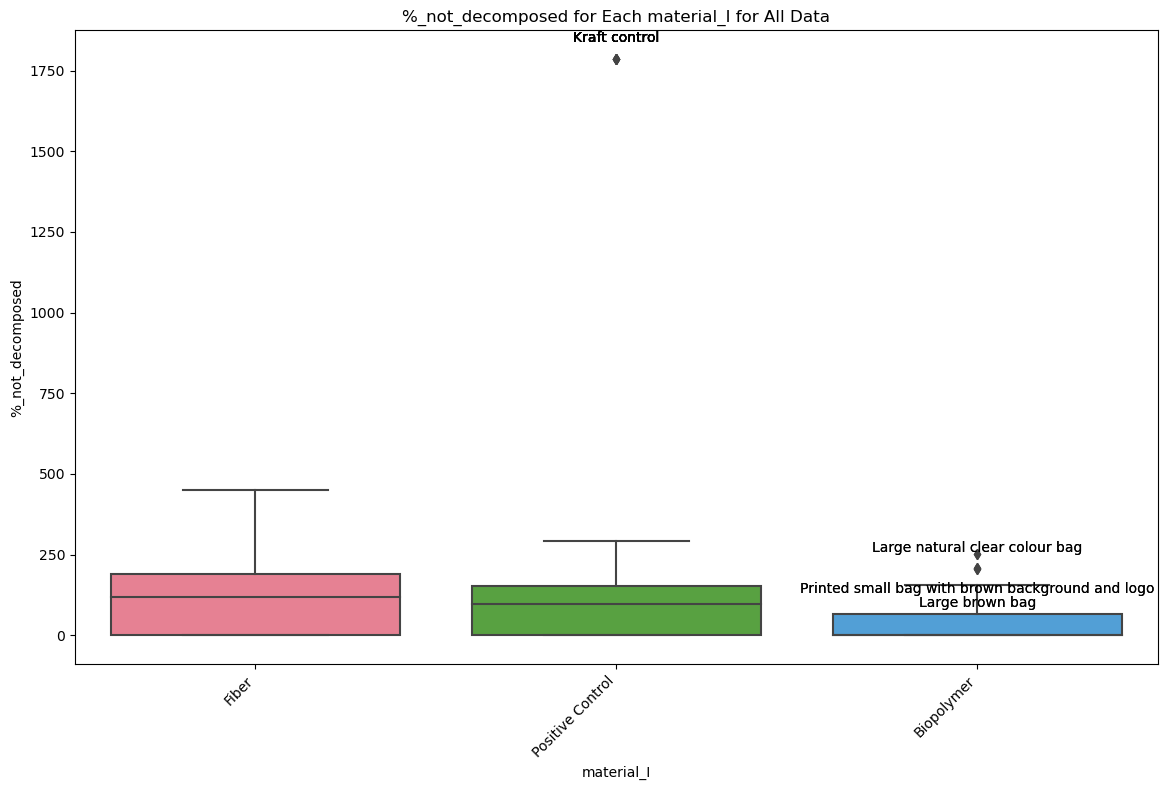

In [12]:
bar_whisker_plot_annotate(df_end, 'material_I', '%_not_decomposed', 'for All Data')

- The findings show fiber with the highest residuals, followed by positive control, and biopolymers with the least. 

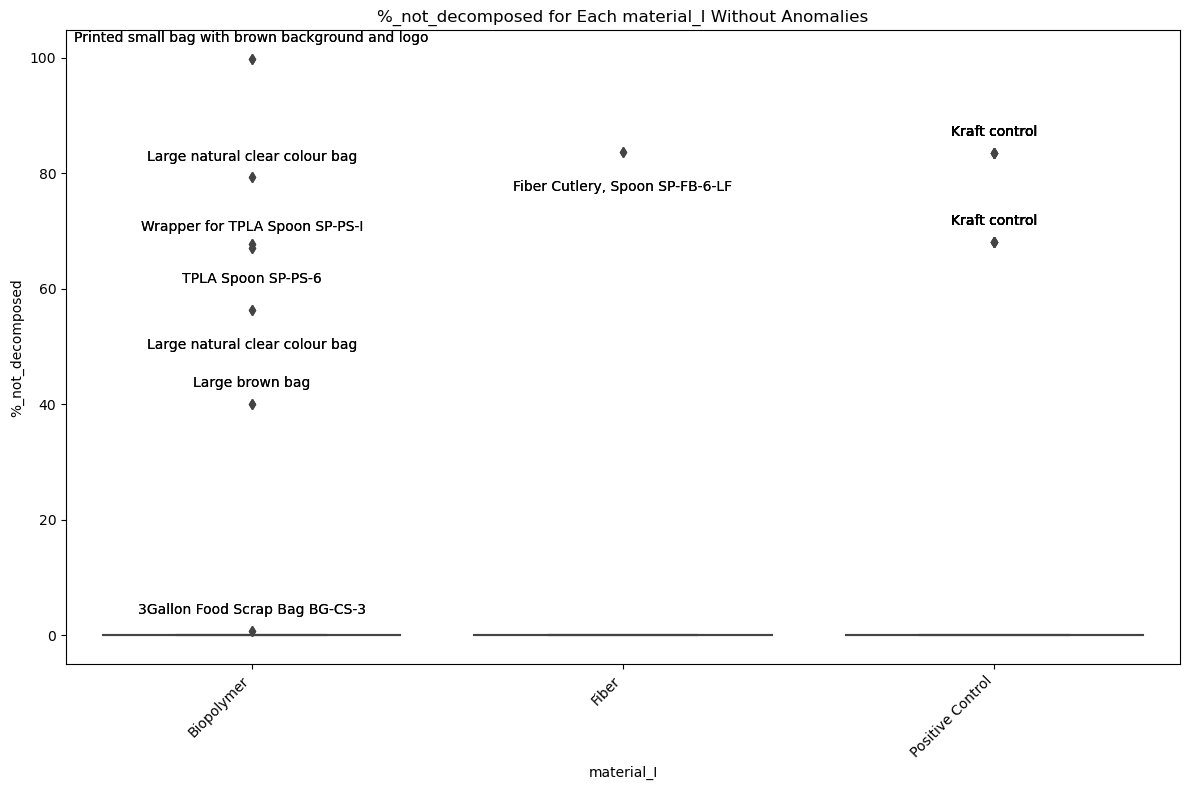

In [13]:
bar_whisker_plot_annotate(df_non_outlier, 'material_I', '%_not_decomposed', 'Without Anomalies')

- Without anomalies, all materials show zero residuals, but biopolymers exhibit more outliers than fiber. 

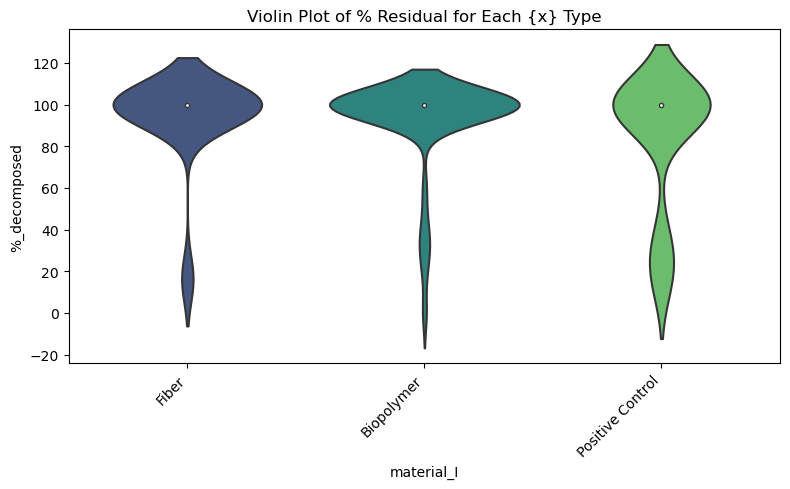

In [14]:
plot_violin(df_non_outlier, 'material_I', '%_decomposed')

## % Residual by Material Class II


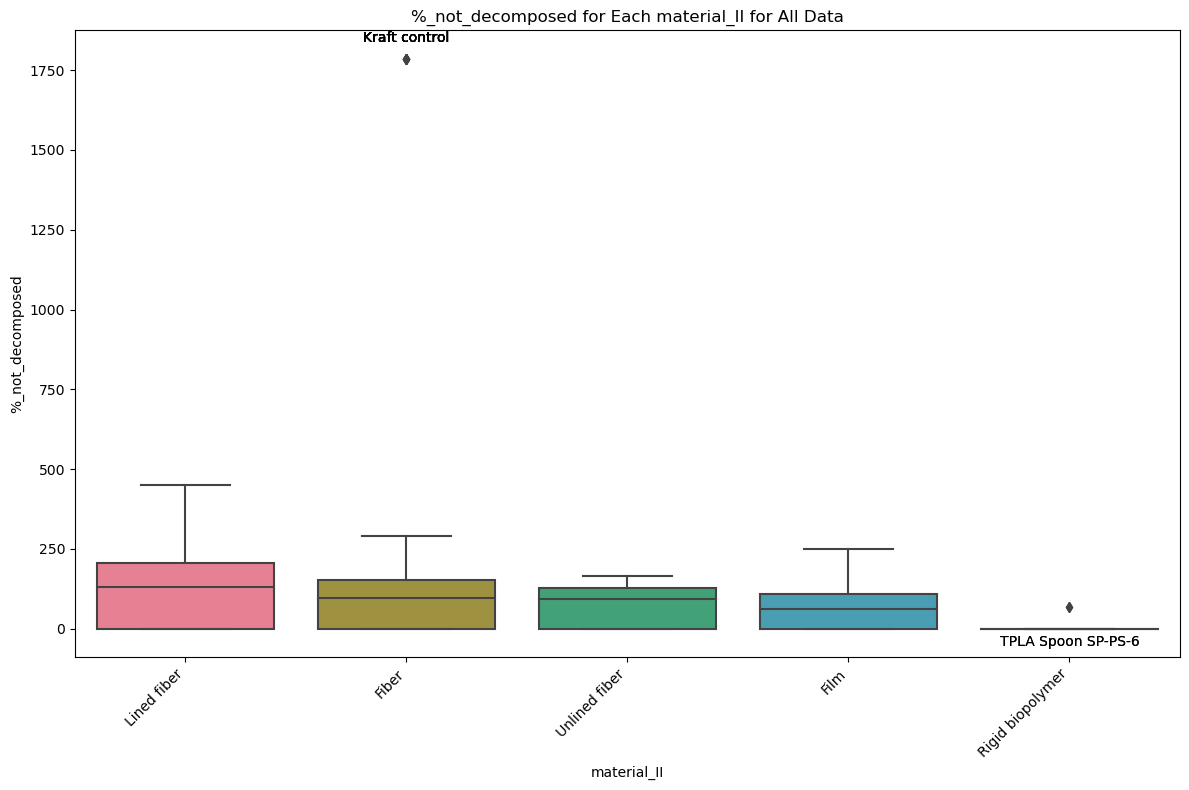

In [15]:
bar_whisker_plot_annotate(df_end, 'material_II', '%_not_decomposed', 'for All Data')

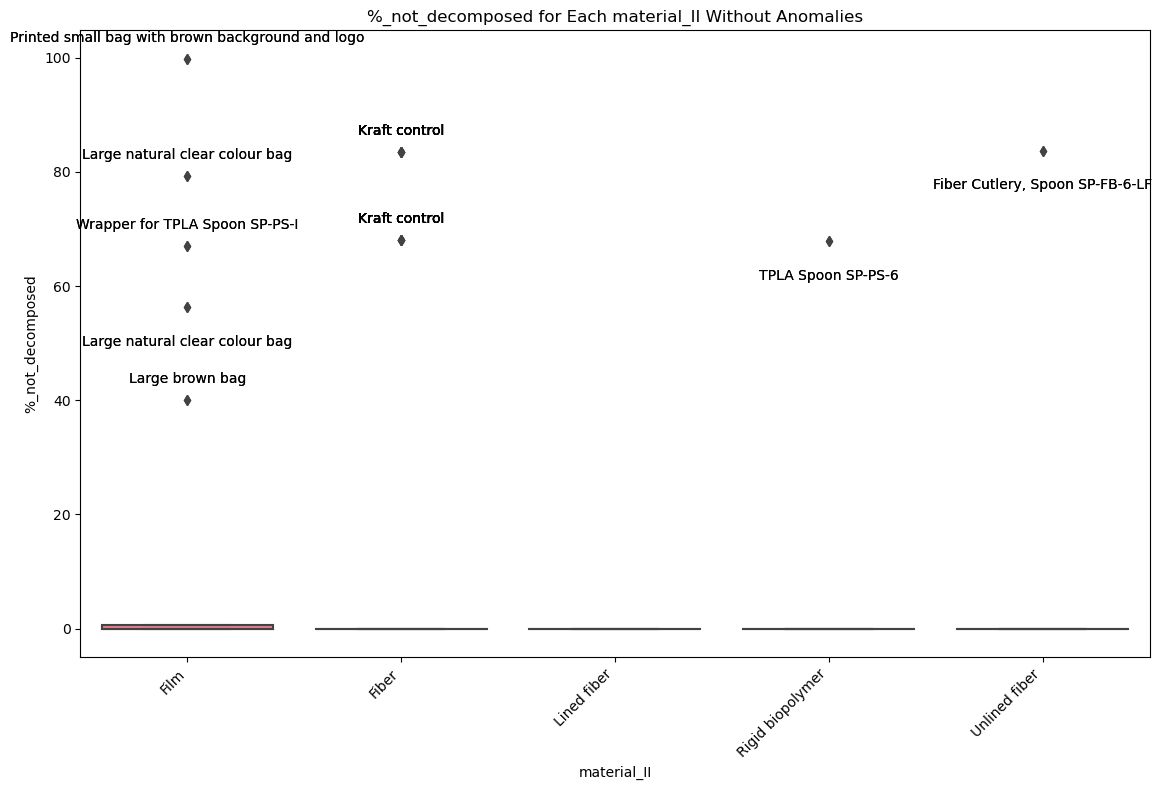

In [16]:
bar_whisker_plot_annotate(df_non_outlier, 'material_II', '%_not_decomposed', 'Without Anomalies')

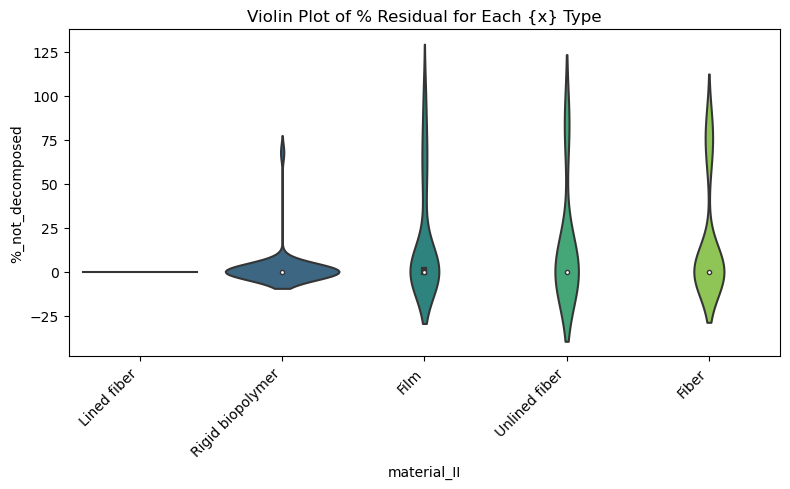

In [17]:
plot_violin(df_non_outlier, 'material_II', '%_not_decomposed')

## % Residual by Material Class III

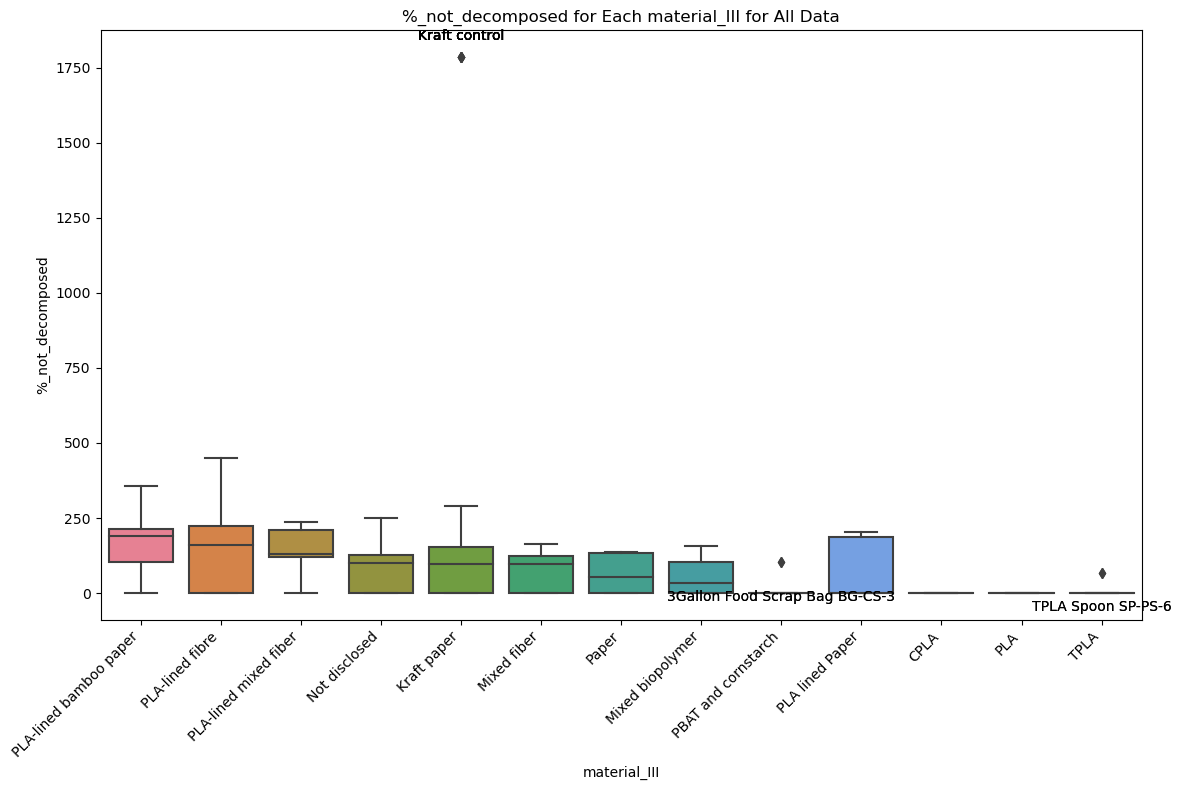

In [18]:
bar_whisker_plot_annotate(df_end, 'material_III', '%_not_decomposed', 'for All Data')

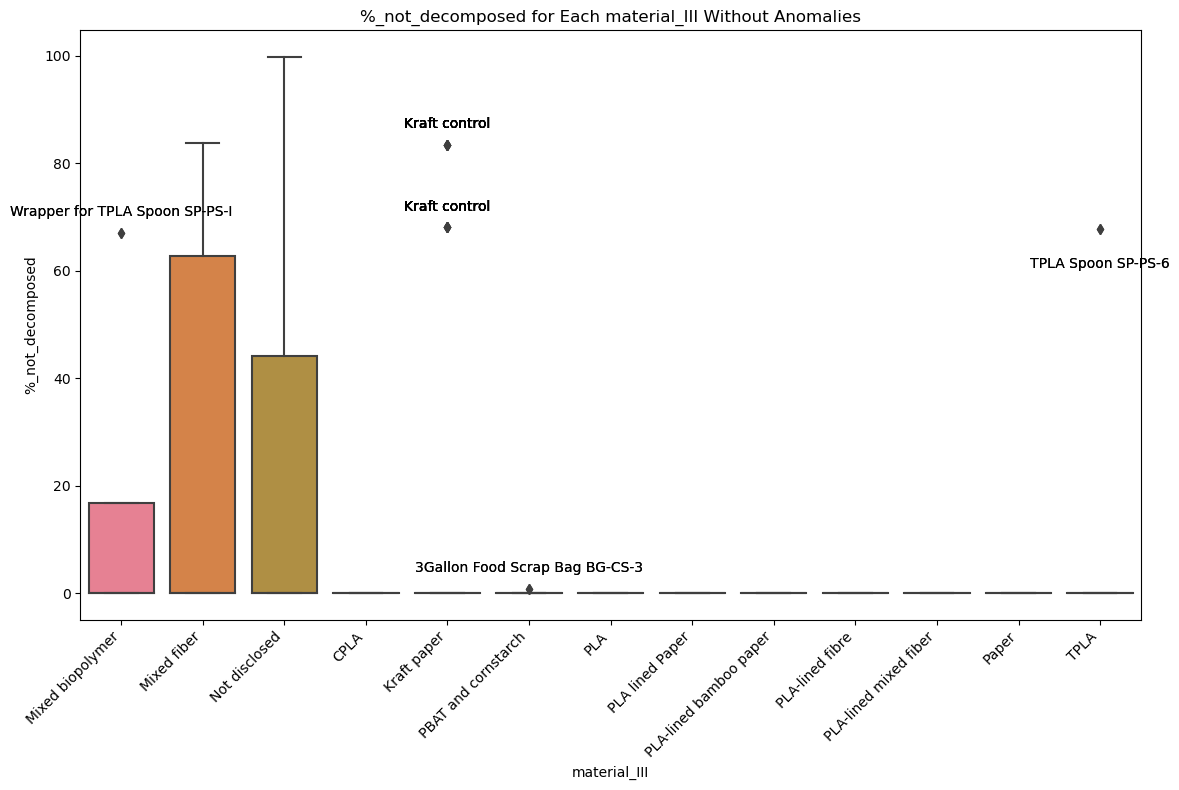

In [19]:
bar_whisker_plot_annotate(df_non_outlier, 'material_III', '%_not_decomposed', 'Without Anomalies')

## % Residual by Product Brand

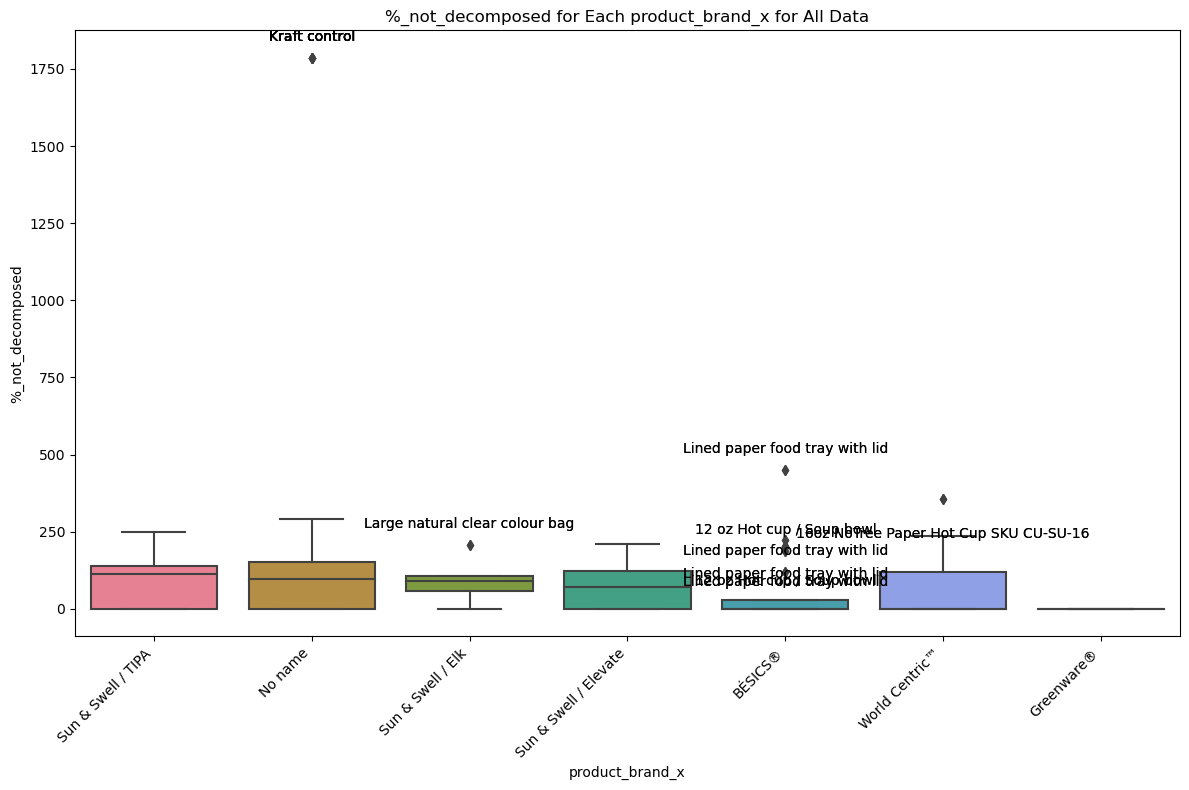

In [20]:
bar_whisker_plot_annotate(df_end, 'product_brand_x', '%_not_decomposed', 'for All Data')

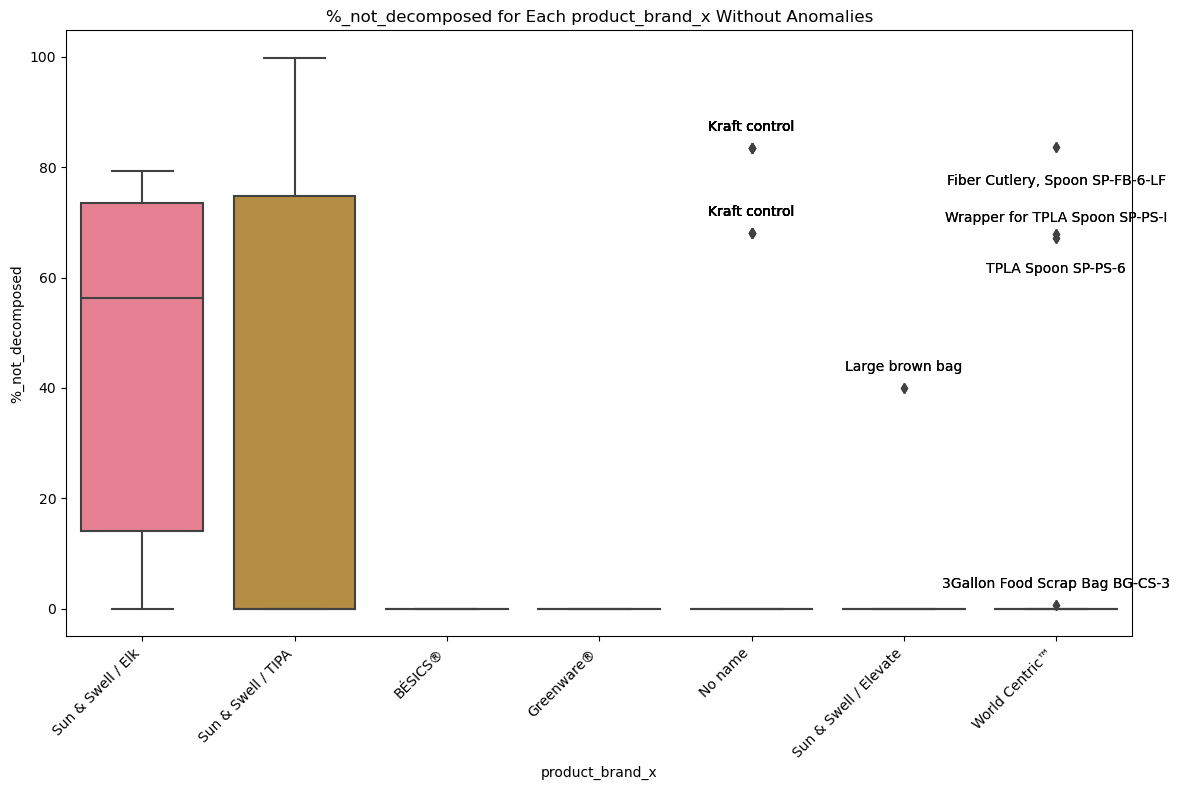

In [21]:
bar_whisker_plot_annotate(df_non_outlier, 'product_brand_x', '%_not_decomposed', 'Without Anomalies')

## % Residual by Bag Placement (Top vs. Bottom)

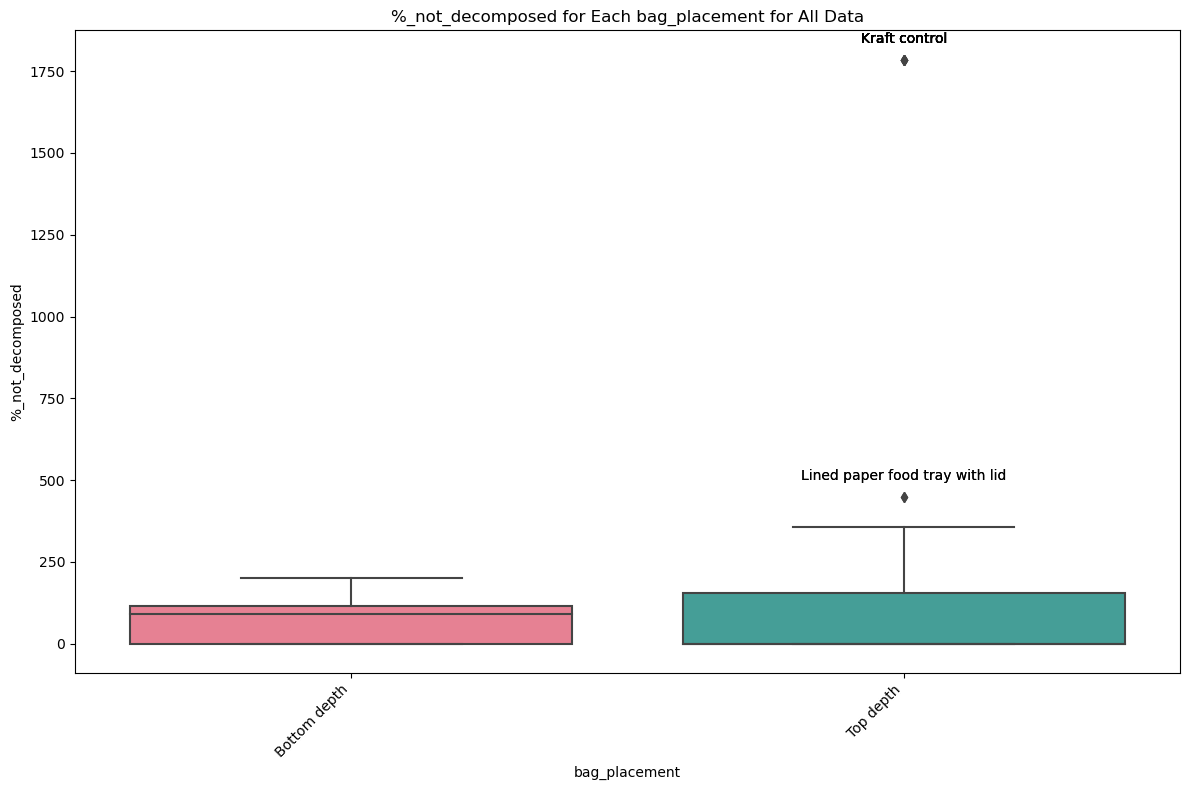

In [22]:
bar_whisker_plot_annotate(df_end, 'bag_placement', '%_not_decomposed', 'for All Data')

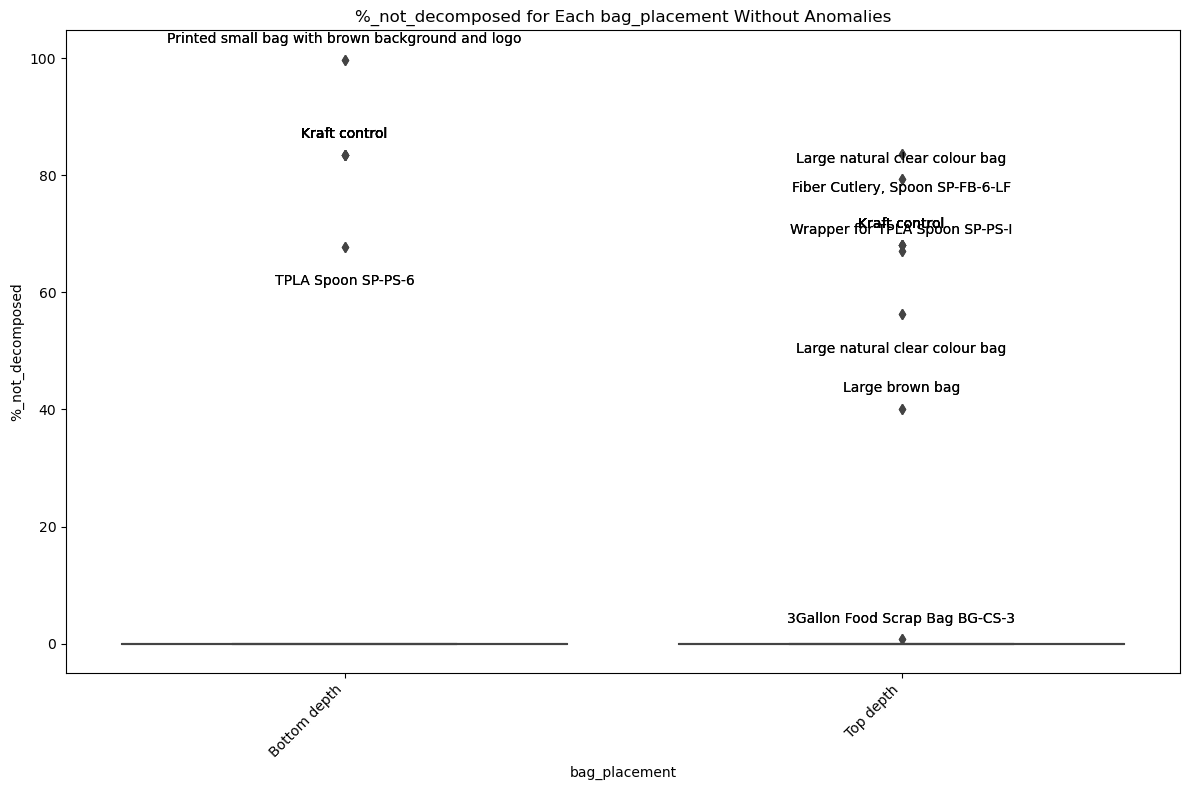

In [23]:
bar_whisker_plot_annotate(df_non_outlier, 'bag_placement', '%_not_decomposed', 'Without Anomalies')

## Actual Distribution Plot by Material

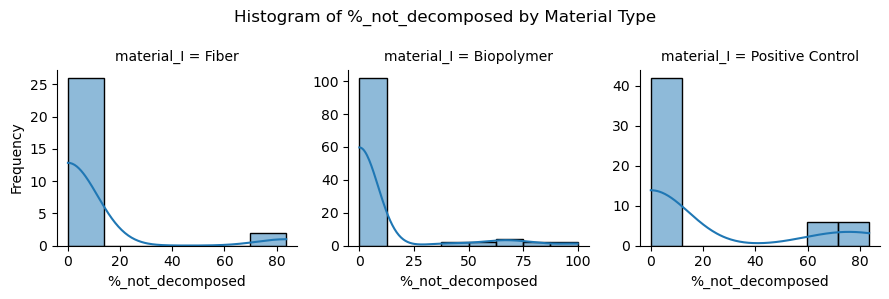

In [24]:
def plot_distribution(df, x, y):
    """
    Plots the distribution of a numerical variable 'y' across categories in 'x', with histograms and KDE.

    Parameters:
    - df (pandas.DataFrame): Dataset containing the variables to be plotted.
    - x (str): Categorical variable name for subplot columns.
    - y (str): Numerical variable name for distribution plotting.

    Creates a grid of histograms (with Kernel Density Estimate, KDE) for 'y' within each category of 'x', using separate subplots for each 'x' category. Each subplot shares y-axis labels but has independent x-axes. The function sets a global title and axis labels, adjusts layout for clarity, and displays the plot.
    """
    g = sns.FacetGrid(df, col=x, col_wrap=3, sharex=False, sharey=False) 
    g.map(sns.histplot, y, kde=True)  # KDE=True adds a density line

    g.fig.suptitle(f'Histogram of {y} by Material Type') 
    g.set_axis_labels(y, 'Frequency')

    g.tight_layout()
    plt.show()

plot_distribution(df_non_outlier, 'material_I', '%_not_decomposed')